<a href="https://colab.research.google.com/github/YambesaRoro/SpringAssignement1/blob/main/GIS_Tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: install dependincies

In [ ]:
# install python libraries
!pip install earthengine-api geemap pandas numpy scipy statsmodels climate_indices matplotlib seaborn


In [ ]:
# Load the libraries and connect to your GEE project
import ee
import geemap
ee.Authenticate()
ee.Initialize(project="ee-mbasayambesa")

## Load the libraries and connect to your GEE project

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Connect to Google Drive

In [ ]:
# Load South Africa boundary
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
sa = countries.filter(ee.Filter.eq('country_na', 'South Africa'))
sa_geom = sa.geometry()
# Dynamic 20-year period (from 20 years ago to current date)
current_date = ee.Date('2025-08-01') # Fixed as per context
START = current_date.advance(-20, 'year').format('YYYY-MM-dd')
END = current_date.format('YYYY-MM-dd')
# Visualize boundary
Map = geemap.Map()
Map.addLayer(sa, {}, 'South Africa')
Map.centerObject(sa, 5)
Map


Map(center=[-28.975081121649033, 25.20179946159188], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
def load_chirps_monthly():
  chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
  .filterDate(START, END) \
  .filterBounds(sa_geom)
  def monthly_sum(img):
    month = ee.Date(img.get('system:time_start')).format('YYYY-MM')
    return img.set('month', month)
  chirps_with_month = chirps.map(monthly_sum)
  months = chirps_with_month.aggregate_array('month').distinct()
  def by_month(m):
    coll = chirps_with_month.filter(ee.Filter.eq('month', m))
    return coll.select('precipitation').sum() \
    .set('system:time_start', ee.Date(m).millis()) \
    .set('month', m)
  return ee.ImageCollection(months.map(by_month))
rain_monthly = load_chirps_monthly()
print('CHIRPS monthly images loaded:', rain_monthly.size().getInfo())

CHIRPS monthly images loaded: 239


# Load South Africa boundary
# Dynamic 20-year period (from 20 years ago to current date)
# Visualize boundary


# Connect to Google Drive

In [ ]:
# Load TerraClimate monthly data
def load_terraclimate_monthly():
 tc = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE') \
 .filterDate(START, END) \
 .filterBounds(sa_geom)
 # Compute mean temperature from max/min bands
 temp = tc.map(lambda img: img.expression('(tmmx + tmmn) / 2', {
 'tmmx': img.select('tmmx'),
 'tmmn': img.select('tmmn')
 }).rename('temp').copyProperties(img, ['system:time_start']))
 pet = tc.select('pet')
 soil = tc.select('soil').map(lambda img: img.rename('soil_moist'))
 return temp, pet, soil
# Print the number of the data (images)
temp_monthly, pet_monthly, soil_monthly = load_terraclimate_monthly()
print('TerraClimate temp images:', temp_monthly.size().getInfo())
print('TerraClimate PET images:', pet_monthly.size().getInfo())
print('TerraClimate soil images:', soil_monthly.size().getInfo())


TerraClimate temp images: 233
TerraClimate PET images: 233
TerraClimate soil images: 233


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import libraries
!pip install rasterio  # Install rasterio using pip
import numpy as np
import rasterio
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

# Step 3: Set file paths (change these to your actual paths in Drive)
csv_path = '/content/drive/MyDrive/GIS_521_Tutorials/Tutorial_1/Data/sa_drought_data.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.0 MB/s eta 0:00:00


In [ ]:
# Load MODIS monthly NDVI and compute VCI. Print size to verify.
def load_modis_ndvi_and_vci():
  modis = ee.ImageCollection('MODIS/061/MOD13A3') \
  .filterDate(START, END) \
  .filterBounds(sa_geom) \
  .select('NDVI')
  def add_vci(img):
    month = ee.Date(img.get('system:time_start')).get('month')
    same_month = modis.filter(ee.Filter.calendarRange(month, month, 'month'))
    ndvi_min = same_month.reduce(ee.Reducer.min()).select('NDVI_min').rename('NDVI')
    ndvi_max = same_month.reduce(ee.Reducer.max()).select('NDVI_max').rename('NDVI')
    vci = img.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).multiply(100).rename('VCI')
    return img.addBands(vci).copyProperties(img, ['system:time_start'])
  return modis.map(add_vci)
ndvi_vci_monthly = load_modis_ndvi_and_vci()
print('MODIS NDVI/VCI images:', ndvi_vci_monthly.size().getInfo())

MODIS NDVI/VCI images: 239


In [ ]:
# Clip VCI collection to South Africa for later mapping
vci_clipped = ndvi_vci_monthly.map(lambda img: img.clip(sa_geom).select('VCI'))
print('Clipped VCI images:', vci_clipped.size().getInfo())


Clipped VCI images: 239


In [ ]:
import time
import os
from tqdm import tqdm
# Join collections by time for unified sampling
joined = rain_monthly.map(lambda rain: ee.Image.cat([
 rain.rename('precipitation'),
 ee.Algorithms.If(
 temp_monthly.filterDate(rain.get('system:time_start'), ee.Date(rain.get('system:time_start')).advance(1,
'month')).size().gt(0),
 temp_monthly.filterDate(rain.get('system:time_start'), ee.Date(rain.get('system:time_start')).advance(1,
'month')).first(),
 ee.Image(0).rename('temp')
 ),
 ee.Algorithms.If(
 pet_monthly.filterDate(rain.get('system:time_start'), ee.Date(rain.get('system:time_start')).advance(1,
'month')).size().gt(0),
 pet_monthly.filterDate(rain.get('system:time_start'), ee.Date(rain.get('system:time_start')).advance(1,
'month')).first(),
 ee.Image(0).rename('pet')
 ),
 ee.Algorithms.If(
 soil_monthly.filterDate(rain.get('system:time_start'), ee.Date(rain.get('system:time_start')).advance(1,
'month')).size().gt(0),
 soil_monthly.filterDate(rain.get('system:time_start'), ee.Date(rain.get('system:time_start')).advance(1,
'month')).first(),
 ee.Image(0).rename('soil_moist')
 ),
 ee.Algorithms.If(
 ndvi_vci_monthly.filterDate(rain.get('system:time_start'),
ee.Date(rain.get('system:time_start')).advance(1, 'month')).size().gt(0),
 ndvi_vci_monthly.filterDate(rain.get('system:time_start'),
ee.Date(rain.get('system:time_start')).advance(1, 'month')).first(),
 ee.Image([0, 0]).rename(['NDVI', 'VCI'])
 )
]))
# Sample data means over SA geometry
samples = joined.map(lambda img:
 ee.Feature(None, img.reduceRegion(
 reducer=ee.Reducer.mean(),
 geometry=sa_geom,
 scale=10000,
 bestEffort=True
 ).set('date', ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')))
)
fc = ee.FeatureCollection(samples)
# Export to Drive
export_task = ee.batch.Export.table.toDrive(
 collection=fc,
 description='sa_drought_data',
 fileFormat='CSV',
 folder='GIS_521_Tutorials/Tutorial_1/Data' # As requested
)
export_task.start()
max_wait_minutes = 10
start_time = time.time()
with tqdm(desc="Exporting", bar_format="{desc}: {elapsed}", total=None) as pbar:
 while export_task.active():
  if (time.time() - start_time) > (max_wait_minutes * 60):
    print(f"Timeout after {max_wait_minutes} minutes. Check GEE console for task status.")
    break
  time.sleep(10)
  pbar.update()
print('Export complete! If timed out, monitor in GEE console.')



Exporting: 08:55

Export complete! If timed out, monitor in GEE console.


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import libraries
!pip install rasterio  # Install rasterio using pip
import numpy as np
import rasterio
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

# Step 3: Set file paths (change these to your actual paths in Drive)
csv_path = '/content/drive/MyDrive/GIS_521_Tutorials/sa_drought_data.csv'
df = pd.read_csv(csv_path)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
# Rename data columns for clarity
df.rename(columns={'precipitation': 'rain', 'NDVI': 'ndvi', 'VCI': 'vci', 'soil_moist': 'soil'}, inplace=True)
print('Sampled DataFrame head:')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sampled DataFrame head:


,system:index,ndvi,vci,pet,rain,soil,temp,.geo
date,,,,,,,,
2005-08-01,0,2695.040301,39.562178,1070.817025,11.753138,25.312999,137.738419,"{""type"":""MultiPoint"",""coordinates"":[]}"
2005-09-01,1,2592.936750,33.064793,1371.187890,9.818070,20.486608,175.671230,"{""type"":""MultiPoint"",""coordinates"":[]}"
2005-10-01,2,2560.682374,25.652427,1735.902378,29.031329,18.104316,196.737382,"{""type"":""MultiPoint"",""coordinates"":[]}"
2005-11-01,3,2834.181544,32.678092,1784.728968,61.755995,27.589566,211.934563,"{""type"":""MultiPoint"",""coordinates"":[]}"
2005-12-01,4,3219.133161,34.780686,2001.172359,37.495188,22.573880,221.063363,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats # For gamma and pearson3 distributions
# Scale TerraClimate data (multiply by 0.1 for actual units: °C for temp, mm for pet/soil)
df['temp'] *= 0.1
df['pet'] *= 0.1
df['soil'] *= 0.1
# Drop the unnecessary columns from the table.
columns_to_drop = ['system:index', '.geo']
df.drop([col for col in columns_to_drop if col in df.columns], axis=1, inplace=True, errors='ignore')
# Compute SPI (1-month scale, gamma distribution)
def compute_spi_custom(precip, calibration_start=2005, calibration_end=2025):
 # Filter calibration period
 calib_mask = (df.index.year >= calibration_start) & (df.index.year <= calibration_end)
 calib_precip = precip[calib_mask]

 # Group by month and fit gamma distribution per month
 spi = np.zeros_like(precip) * np.nan
 for month in range(1, 13):
  month_mask = (df.index.month == month)
  month_precip = calib_precip[df.index.month[calib_mask] == month]

  # Fit gamma (skip if all zero or invalid)
  if np.sum(month_precip > 0) > 0:
   shape, loc, scale = stats.gamma.fit(month_precip[month_precip > 0])
   cdf = np.zeros_like(precip[month_mask])
   pos = precip[month_mask] > 0
   cdf[pos] = stats.gamma.cdf(precip[month_mask][pos], shape, loc, scale)
   # Adjust for zeros (empirical correction)
   zero_prob = np.sum(month_precip == 0) / len(month_precip)
   cdf = zero_prob + (1 - zero_prob) * cdf
   # Standardize to normal distribution
   spi[month_mask] = stats.norm.ppf(cdf)

 return spi
df['spi'] = compute_spi_custom(df['rain'].values)
# Compute SPEI (1-month scale, Pearson Type III distribution)
def compute_spei_custom(precip, pet, calibration_start=2005, calibration_end=2025):
# Compute water balance D = precip - pet
 D = precip - pet

# Filter calibration period
 calib_mask = (df.index.year >= calibration_start) & (df.index.year <= calibration_end)
 calib_D = D[calib_mask]

# Group by month and fit Pearson Type III per month
 spei = np.zeros_like(D) * np.nan
 for month in range(1, 13):
  month_mask = (df.index.month == month)
  month_D = calib_D[df.index.month[calib_mask] == month]

  # Fit Pearson Type III
  if len(month_D) > 0 and np.std(month_D) > 0:
   shape, loc, scale = stats.pearson3.fit(month_D)
   cdf = stats.pearson3.cdf(D[month_mask], shape, loc, scale)
   # Standardize to normal distribution
   spei[month_mask] = stats.norm.ppf(cdf)

 return spei
df['spei'] = compute_spei_custom(df['rain'].values, df['pet'].values)
print('DataFrame with indices:')
df.head()

DataFrame with indices:


,ndvi,vci,pet,rain,soil,temp,spi,spei
date,,,,,,,,
2005-08-01,2695.040301,39.562178,107.081702,11.753138,2.531300,13.773842,0.136573,-0.045443
2005-09-01,2592.936750,33.064793,137.118789,9.818070,2.048661,17.567123,-1.039170,-1.055342
2005-10-01,2560.682374,25.652427,173.590238,29.031329,1.810432,19.673738,-0.324008,-0.325623
2005-11-01,2834.181544,32.678092,178.472897,61.755995,2.758957,21.193456,0.850305,0.757770
2005-12-01,3219.133161,34.780686,200.117236,37.495188,2.257388,22.106336,-1.796897,-1.390853


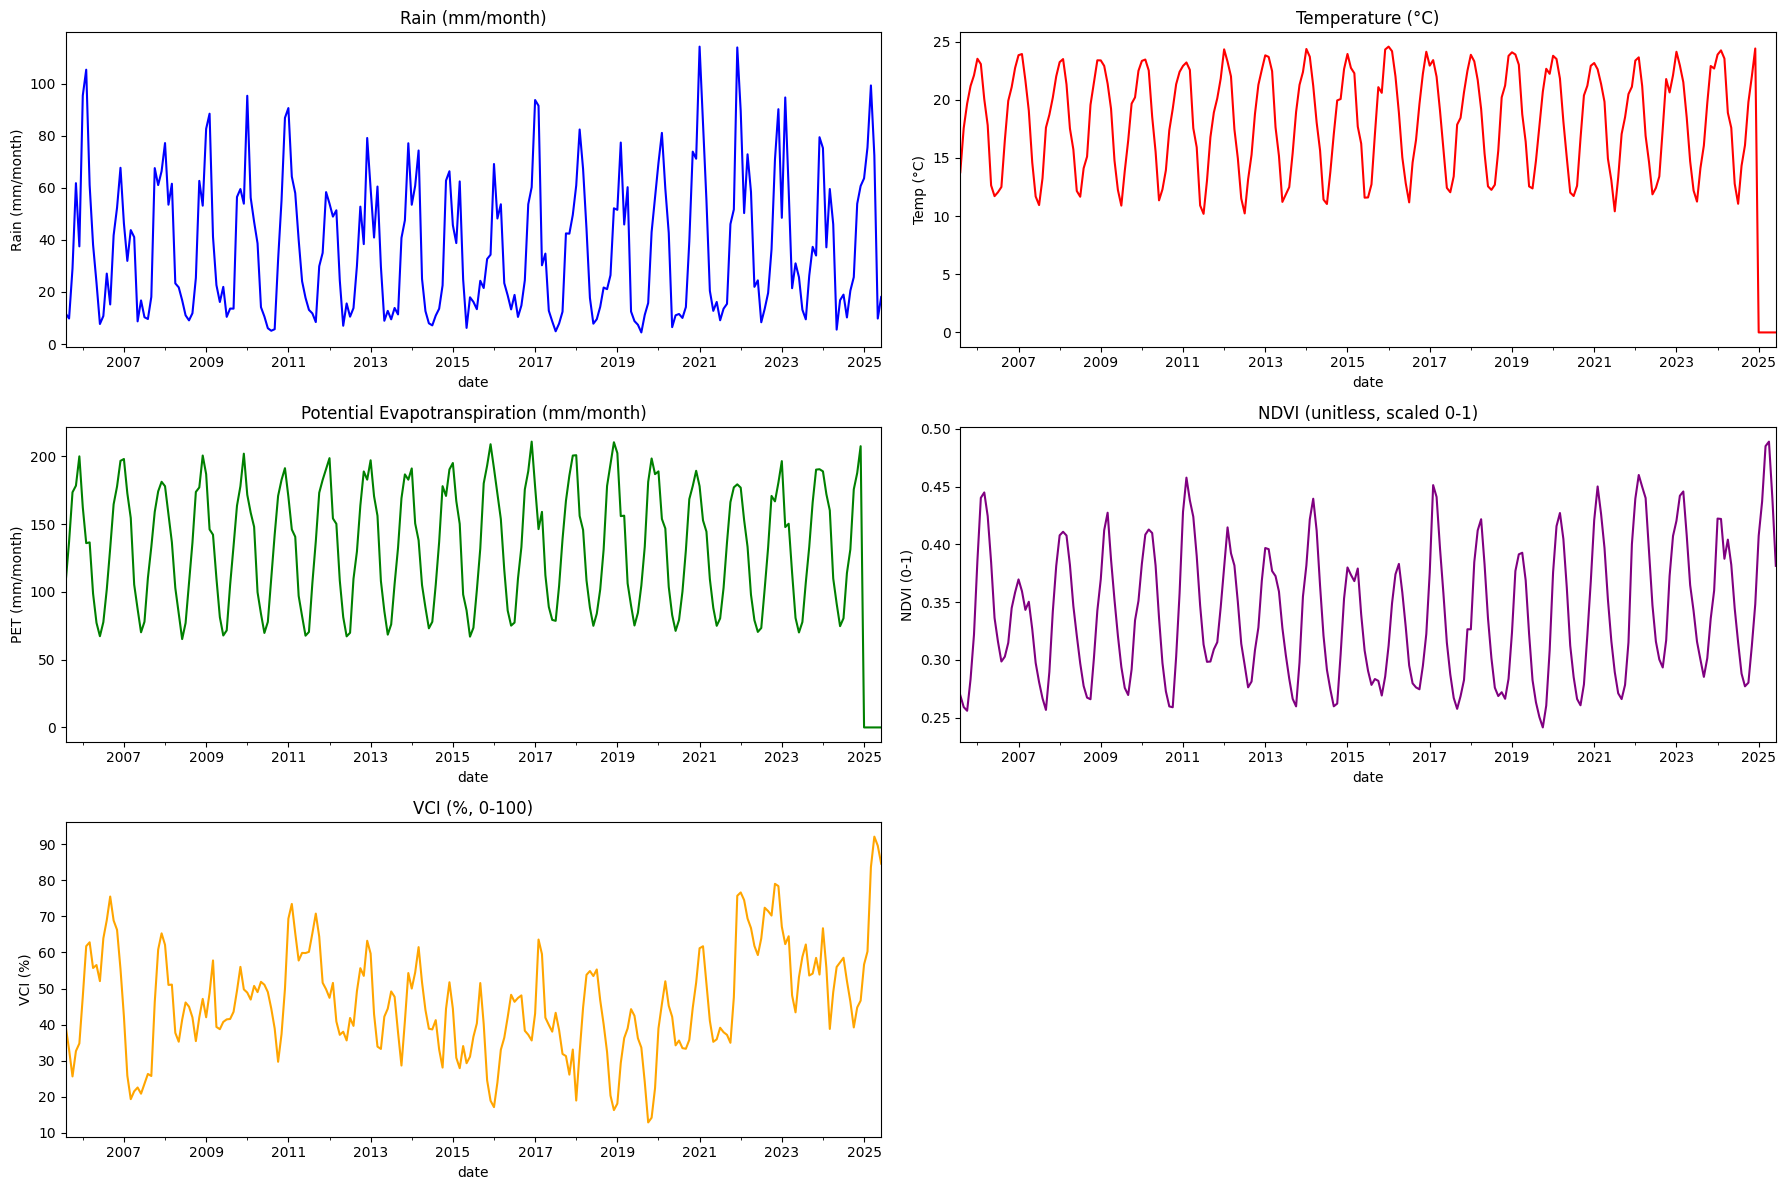

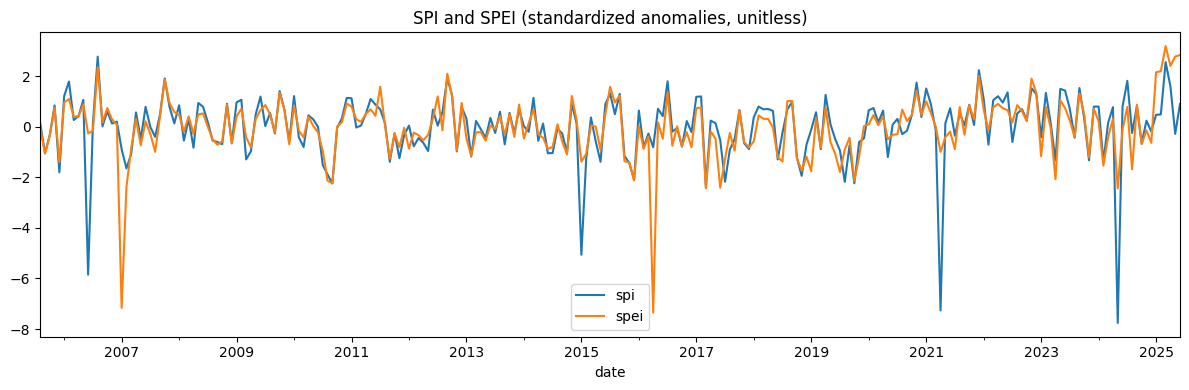

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Additional scaling for NDVI (MODIS NDVI is integer-scaled; multiply by 0.0001 for actual unitless -0.2 to 1 range)
df['ndvi'] *= 0.0001
# Separate Timeseries Plots
fig, ax = plt.subplots(3, 2, figsize=(18, 12)) # 3 rows, 2 columns for side-by-side layout
# Plot Rain
df['rain'].plot(ax=ax[0, 0], title='Rain (mm/month)', color='blue')
ax[0, 0].set_ylabel('Rain (mm/month)')
# Plot Temp
df['temp'].plot(ax=ax[0, 1], title='Temperature (°C)', color='red')
ax[0, 1].set_ylabel('Temp (°C)')
# Plot PET
df['pet'].plot(ax=ax[1, 0], title='Potential Evapotranspiration (mm/month)', color='green')
ax[1, 0].set_ylabel('PET (mm/month)')
# Plot NDVI
df['ndvi'].plot(ax=ax[1, 1], title='NDVI (unitless, scaled 0-1)', color='purple')
ax[1, 1].set_ylabel('NDVI (0-1)')
# Plot VCI
df['vci'].plot(ax=ax[2, 0], title='VCI (%, 0-100)', color='orange')
ax[2, 0].set_ylabel('VCI (%)')
# Hide the unused subplot
ax[2, 1].axis('off')
plt.tight_layout()
plt.show()
# Keep SPI and SPEI together as they are comparable indices
fig, ax = plt.subplots(figsize=(12, 4))
df[['spi', 'spei']].plot(ax=ax, title='SPI and SPEI (standardized anomalies, unitless)')
plt.tight_layout()
plt.show()

Correlation Matrix:
          rain      temp       pet      soil      ndvi       vci       spi  \
rain  1.000000  0.575770  0.532408  0.471579  0.584972  0.272616  0.386282   
temp  0.575770  1.000000  0.907235  0.318459  0.221659 -0.166034 -0.106802   
pet   0.532408  0.907235  1.000000  0.119694 -0.045982 -0.184098 -0.084314   
soil  0.471579  0.318459  0.119694  1.000000  0.536104  0.352633  0.229556   
ndvi  0.584972  0.221659 -0.045982  0.536104  1.000000  0.531233  0.121291   
vci   0.272616 -0.166034 -0.184098  0.352633  0.531233  1.000000  0.270541   
spi   0.386282 -0.106802 -0.084314  0.229556  0.121291  0.270541  1.000000   
spei  0.327118 -0.281718 -0.245828  0.198534  0.164759  0.419526  0.636310   

          spei  
rain  0.327118  
temp -0.281718  
pet  -0.245828  
soil  0.198534  
ndvi  0.164759  
vci   0.419526  
spi   0.636310  
spei  1.000000  


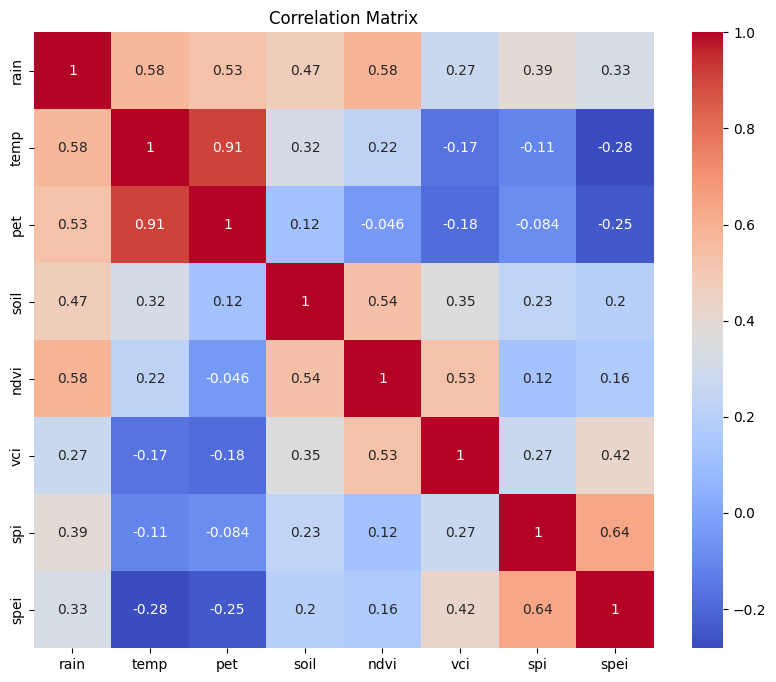

In [ ]:
# Correlation matrix (Pearson)
corr = df[['rain', 'temp', 'pet', 'soil', 'ndvi', 'vci', 'spi', 'spei']].corr()
print('Correlation Matrix:')
print(corr)
# Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Load Eastern Cape province boundary from GEE admin dataset
provinces = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM0_NAME', 'South Africa'))
eastern_cape_collection = provinces.filter(ee.Filter.eq('ADM1_NAME', 'Eastern Cape'))
eastern_cape = eastern_cape_collection.geometry().dissolve()

In [ ]:
# Update period to past 5 years
current_date = ee.Date('2025-07-31')
START = current_date.advance(-5, 'year').format('YYYY-MM-dd')
END = current_date.format('YYYY-MM-dd')
# Compute mean images for to Eastern Cape
mean_rain = rain_monthly.mean().clip(eastern_cape)
mean_temp = temp_monthly.mean().clip(eastern_cape)
mean_pet = pet_monthly.mean().clip(eastern_cape)
mean_soil = soil_monthly.mean().clip(eastern_cape)
mean_ndvi = ndvi_vci_monthly.select('NDVI').mean().clip(eastern_cape)
# Visualization parameters for the added layers
vis_params = {
 'rain': {'min': 0, 'max': 100, 'palette': ['white', 'blue', 'darkblue']}, # mm/month
 'temp': {'min': 10, 'max': 30, 'palette': ['blue', 'yellow', 'red']}, # °C
 'pet': {'min': 50, 'max': 200, 'palette': ['green', 'yellow', 'red']}, # mm/month
 'soil': {'min': 0, 'max': 100, 'palette': ['white', 'brown', '#8B4513']}, # mm;
 'ndvi': {'min': 0, 'max': 0.8, 'palette': ['brown', 'yellow', 'green']}, # unitless 0-1
}
# Load the interactive Map
Map = geemap.Map()
# Verify image projection, normalise resolution to 20km
coarse_proj = ee.Projection('EPSG:4326').atScale(20000)
Map.addLayer(mean_rain.resample('bicubic').reproject(coarse_proj), {**vis_params['rain'], 'reduceResolution':
True, 'maxPixels': 1048576}, 'Mean Rain (Eastern Cape)')
Map.addLayer(mean_temp.resample('bicubic').reproject(coarse_proj), {**vis_params['temp'],
'reduceResolution': True, 'maxPixels': 1048576}, 'Mean Temperature (Eastern Cape)')
Map.addLayer(mean_pet.resample('bicubic').reproject(coarse_proj), {**vis_params['pet'], 'reduceResolution':
True, 'maxPixels': 1048576}, 'Mean PET (Eastern Cape)')
Map.addLayer(mean_soil.resample('bicubic').reproject(coarse_proj), {**vis_params['soil'], 'reduceResolution':
True, 'maxPixels': 1048576}, 'Mean Soil Moisture (Eastern Cape)')
Map.addLayer(mean_ndvi.resample('bicubic').reproject(coarse_proj), {**vis_params['ndvi'], 'reduceResolution':
True, 'maxPixels': 1048576}, 'Mean NDVI (Eastern Cape)')
Map.centerObject(eastern_cape, 6) # Zoom to Eastern Cape
Map

Map(center=[-32.15430828779869, 26.468644563456426], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Export the data to the Google Drive
parameters = ['rain', 'temp', 'pet', 'soil', 'ndvi']
means = [mean_rain, mean_temp, mean_pet, mean_soil, mean_ndvi]
for param, mean_img in zip(parameters, means):
 try:
  ee.batch.Export.image.toDrive(
  image=mean_img,
  description=f'mean_{param}_eastern_cape',
  scale=2000,
  region=eastern_cape,
  fileFormat='GeoTIFF',
  folder='GIS_521_Tutorials'
  ).start()
  print(f'Export started for mean_{param}_eastern_cape! Check Drive in a few minutes.')
 except Exception as e:
  print(f'Export failed for {param}: {e}. Try increasing scale to 5000m.')

Export started for mean_rain_eastern_cape! Check Drive in a few minutes.
Export started for mean_temp_eastern_cape! Check Drive in a few minutes.
Export started for mean_pet_eastern_cape! Check Drive in a few minutes.
Export started for mean_soil_eastern_cape! Check Drive in a few minutes.
Export started for mean_ndvi_eastern_cape! Check Drive in a few minutes.
